### Deep Network Cascade for image Super-resolution 

#### NLSS implementation 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
img_gray = cv2.imread('../image/sky.jpeg')

In [3]:
def gaussiand_2_level_pyramid(img,kernal_size):
    
    blur_1 = cv2.GaussianBlur(img,(kernal_size,kernal_size),0)
    [h,w,c]  = blur_1.shape
    ## down_sample the blur1 and apply gaussian again 
    d_blur_1 = cv2.resize(blur_1, (0,0), fx=0.5, fy=0.5) 
    d_blur_2 = cv2.GaussianBlur(d_blur_1,(kernal_size,kernal_size),0)
    ## upsample image 
    blur_2 = cv2.resize(d_blur_2,(w,h),0,0, interpolation = cv2.INTER_NEAREST)
    return blur_1, blur_2

In [4]:
def NLSS_serach(img_gray,patch_size,kernal_size):
    ## apply bicubic interpolation 
    img_gray_scale = cv2.resize(img_gray,(0,0),fx=1.37,fy=1.37, interpolation = cv2.INTER_CUBIC)
    
    [h,w,c] = img_gray_scale.shape
    out_img = np.zeros([2*h,2*w,c],dtype='uint8')
    overalp_size = round(patch_size/2)
    
    i = 0
    for row in range (0,h-patch_size,overalp_size):
        j = 0
        for col in range (0,w-patch_size,overalp_size):
            
            patch = img_gray_scale [row:row+patch_size,col:col+patch_size]
            ## apply blur in pathand perform down sampling 
            blur_1, blur_2 = gaussiand_2_level_pyramid(patch,kernal_size)
            mean_patch = blur_1/2.0 + blur_2/2.0        ## averaging instead of gaussina
            
            mean_patch.shape
            #out_img[row:row+path_size,col:col+path_size] = mean_patch
            out_img[i:i+patch_size,j:j+patch_size] = mean_patch
        
            j = j+patch_size
        i = i+patch_size    
    return out_img

In [5]:
#blur_1, blur_2 = gaussiand_2_level_pyramid(img_gray,3)

In [6]:
NLSS_img = NLSS_serach(img_gray,56,5)

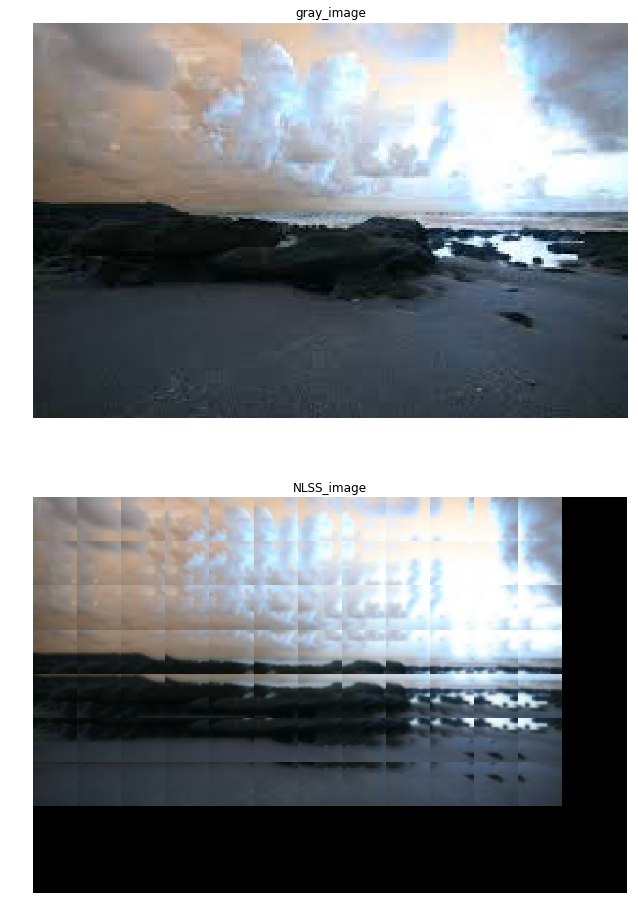

In [7]:
fig=plt.figure(figsize=(16, 16))
columns = 1
rows = 2
fig.add_subplot(rows, columns, 1)
plt.axis("off")
plt.title("gray_image")
plt.imshow(img_gray,cmap='gray')
fig.add_subplot(rows, columns, 2)
plt.axis("off")
plt.title("NLSS_image")
plt.imshow(NLSS_img,cmap='gray')


## Autoencoder basic module 

In [8]:
from IPython.display import Image, SVG
import matplotlib.pyplot as plt

%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.datasets import mnist
from tensorflow.python.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D

from tensorflow.python.keras.models import Model,Sequential
from tensorflow.python.keras.optimizers import RMSprop

/home/lord/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Above is one module of  NLSS with autoencoder . We need to train the full stack of netwotk as it uses back projection like resnet architecture.  

### Retrain the model with NLSS data set 

In [9]:
## read NLSS input image generate patch and 

In [10]:
import glob

In [11]:
# reaf training data #
def load_data_from_images(images_path,label_path):
    
    count = 0
    
    data_images = []
    data_labels = []
    for img_path,label_img_path in zip(glob.glob(images_path),glob.glob(label_path)):
        img = cv2.imread(img_path)
        #label_img = cv2.imread(label_img_path)
        label_img = cv2.imread(label_img_path)
        
        img1_d  =img.reshape(1,56*56*3)
        label_img1_d  =label_img.reshape(1,56*56*3)
        
        data_images.append(img1_d)
        data_labels.append(label_img1_d)
        if(img_path.split('/')[0] ==label_img_path.split('/')[0] ):
            #print(count)
            count=count+1
        
    data_images = np.squeeze(np.array(data_images))
    data_labels = np.squeeze(np.array(data_labels))
    
    
    train_data = data_images[0:80000,:]
    test_data = data_images[80000:-1,:]
    
    train_labels = data_labels[0:80000,:]
    test_labels = data_labels[80000:-1,:]
    
    

    
    
    print(train_data.shape,train_labels.shape)       
    print(test_data.shape,test_labels.shape)    
    print(count)    
    return train_data,train_labels,test_data,test_labels

In [12]:
images_path = '/home/lord/cv_assignment/cv_project/data_set/NLSS_data_set/train/LR/*.jpg'
label_path = '/home/lord/cv_assignment/cv_project/data_set/NLSS_data_set/train/SR/*.jpg'
train_data,train_labels,test_data,test_labels = load_data_from_images(images_path,label_path)



(80000, 9408) (80000, 9408)
(30469, 9408) (30469, 9408)
110470


In [13]:
train_data = train_data.reshape((len(train_data), 56, 56, 3))
train_labels = train_labels.reshape((len(train_labels), 56, 56, 3))
test_data = test_data.reshape((len(test_data), 56, 56, 3))
test_labels = test_labels.reshape((len(test_labels), 56, 56, 3))





In [14]:
max_value1 = float(train_data.max())
max_value2 = float(train_labels.max())
train_data = train_data.astype('float32') / max_value1
test_data = test_data.astype('float32') / max_value1
train_labels = train_labels.astype('float32') / max_value2
test_labels = test_labels.astype('float32') / max_value2


print(train_data.shape,train_labels.shape)       
print(test_data.shape,test_labels.shape)

(80000, 56, 56, 3) (80000, 56, 56, 3)
(30469, 56, 56, 3) (30469, 56, 56, 3)


### First we need train the basic autoencoder from SR images and downsample images with gaussian blur sigma=1,5,10. 

In [15]:
##
autoencoder = Sequential()

# Encoder Layers
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=train_data.shape[1:]))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))

# Decoder Layers
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 56, 56, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        9248      
__________

In [16]:
#autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(train_data, train_labels,
                epochs=100,
                batch_size=128,
                validation_data=(test_data, test_labels))

Train on 80000 samples, validate on 30469 samples
Epoch 1/100
80000/80000 [==============================] - 25s 313us/step - loss: 0.0112 - val_loss: 0.0064
Epoch 2/100
80000/80000 [==============================] - 22s 272us/step - loss: 0.0059 - val_loss: 0.0055
Epoch 3/100
80000/80000 [==============================] - 22s 277us/step - loss: 0.0053 - val_loss: 0.0050
Epoch 4/100
80000/80000 [==============================] - 22s 278us/step - loss: 0.0049 - val_loss: 0.0048
Epoch 5/100
80000/80000 [==============================] - 22s 275us/step - loss: 0.0047 - val_loss: 0.0046
Epoch 6/100
80000/80000 [==============================] - 22s 272us/step - loss: 0.0046 - val_loss: 0.0045
Epoch 7/100
80000/80000 [==============================] - 23s 282us/step - loss: 0.0044 - val_loss: 0.0044
Epoch 8/100
80000/80000 [==============================] - 23s 282us/step - loss: 0.0043 - val_loss: 0.0044
Epoch 9/100
80000/80000 [==============================] - 23s 281us/step - loss: 0.00

Epoch 76/100
80000/80000 [==============================] - 22s 274us/step - loss: 0.0033 - val_loss: 0.0033
Epoch 77/100
80000/80000 [==============================] - 22s 275us/step - loss: 0.0033 - val_loss: 0.0033
Epoch 78/100
80000/80000 [==============================] - 22s 273us/step - loss: 0.0033 - val_loss: 0.0033
Epoch 79/100
80000/80000 [==============================] - 22s 274us/step - loss: 0.0033 - val_loss: 0.0033
Epoch 80/100
80000/80000 [==============================] - 22s 274us/step - loss: 0.0033 - val_loss: 0.0033
Epoch 81/100
80000/80000 [==============================] - 22s 273us/step - loss: 0.0033 - val_loss: 0.0033
Epoch 82/100
80000/80000 [==============================] - 22s 279us/step - loss: 0.0033 - val_loss: 0.0033
Epoch 83/100
80000/80000 [==============================] - 22s 276us/step - loss: 0.0033 - val_loss: 0.0034
Epoch 84/100
80000/80000 [==============================] - 22s 273us/step - loss: 0.0032 - val_loss: 0.0032
Epoch 85/100
80000/

In [17]:
#autoencoder.fit(x_train_noisy, x_train,
#                epochs=1,
#                batch_size=128,
#                validation_data=(x_test_noisy, x_test))

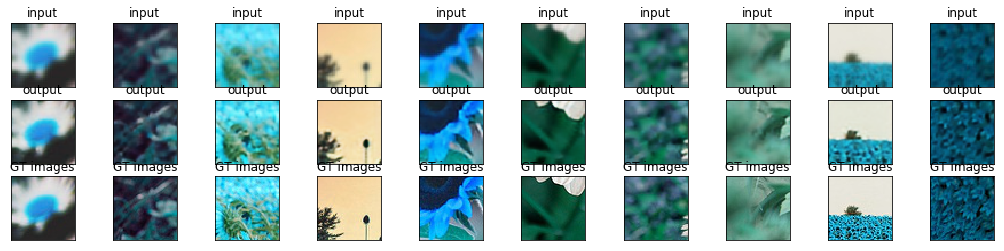

In [30]:
num_images = 10
np.random.seed(42)
random_test_images = np.random.randint(test_data.shape[0], size=num_images)

x_test_denoised = autoencoder.predict(test_data)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(test_data[image_idx].reshape(56,56,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title("input")
    # plot reconstructed image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(x_test_denoised[image_idx].reshape(56,56,3))
    plt.title("output")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #plot GT
    ax = plt.subplot(3, num_images,num_images+ num_images + i + 1)
    plt.imshow(test_labels[image_idx].reshape(56,56,3))
    plt.title("GT images")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## inference part 

In [19]:
def inrfrence_autoencoder(patch,max_value1):
    patch = patch.reshape(1,56,56,3)
    patch = patch.astype('float32') / max_value1
    patch1 = np.squeeze(autoencoder.predict(patch))
    return patch1
    
    ############ normalize the patch 
    
    

In [20]:
def infrence_super_resolution(img,autoencoder,max_value1):
    
    #######################################Repeat NLSS process #########################################
    patch_size = 56
    kernal_size = 5
    img_gray_scale = cv2.resize(img,(0,0),fx=1.37,fy=1.37, interpolation = cv2.INTER_CUBIC)
    
    [h,w,c] = img_gray_scale.shape
    out_img = np.zeros([h,w,c],dtype='float')
    overalp_size = round(patch_size/2)
    
    i = 0
    for row in range (0,h-patch_size,overalp_size):
        j = 0
        for col in range (0,w-patch_size,overalp_size):
            
            patch = img_gray_scale [row:row+patch_size,col:col+patch_size]
            ## apply blur in pathand perform down sampling 
            blur_1, blur_2 = gaussiand_2_level_pyramid(patch,kernal_size)
            mean_patch = blur_1/2.0 + blur_2/2.0        ## averaging instead of gaussina
   #################################################################mean patch is NLSS patch ########################
            ## apply the auencoder inference #######################################
            
            patch1 = inrfrence_autoencoder(mean_patch,max_value1)
            #print(patch1.shape)
            if((row==0)|(col==0)|(row==h-patch_size/2)|(col==w-patch_size/2)):
                out_img[row:row+patch_size,col:col+patch_size] = patch1
            else:
                
                out_img[row:row+patch_size,col:col+patch_size] = out_img[row:row+patch_size,col:col+patch_size]/2.0 + patch1/2.0
    return out_img

In [21]:
img2 = cv2.imread('/home/lord/cv_assignment/cv_project/data_set/images/train/5547758_eea9edfd54_n.jpg')
out_img2 = infrence_super_resolution(img2,autoencoder,max_value1)
out_img3 = infrence_super_resolution(255*out_img2,autoencoder,max_value1)
out_img4 = infrence_super_resolution(255*out_img3,autoencoder,max_value1)

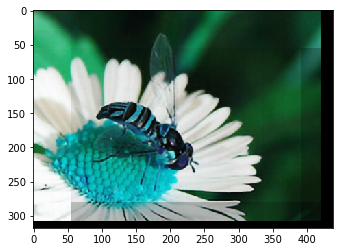

In [22]:
plt.imshow(out_img2.astype('float'))
plt.gray()


In [23]:
255*out_img2[34,35,:].astype('uint8')

array([0, 0, 0], dtype=uint8)

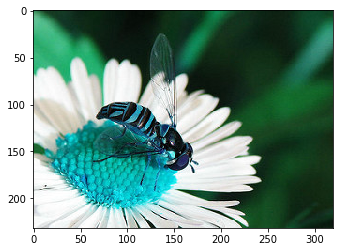

In [24]:
plt.imshow(img2)
plt.gray()

In [25]:
import os
test_folder  = '/home/lord/cv_assignment/cv_project/data_set/images/test_folder/'
images_list = os.listdir(test_folder)



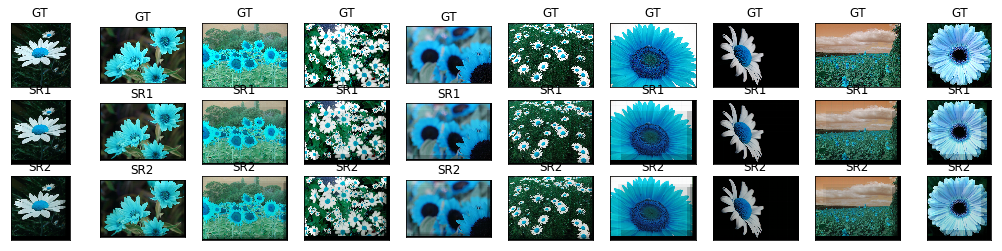

In [26]:
plt.figure(figsize=(18, 4))
num_images = 10

for i in range(len(images_list)):
    # plot original image
    img_in = cv2.imread(test_folder+images_list[i])
    img_out = infrence_super_resolution(img_in,autoencoder,max_value1)
    img_out1 = infrence_super_resolution(255*img_out,autoencoder,max_value1)
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(img_in)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title("GT")
    # plot reconstructed image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(img_out)
    plt.title("SR1")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # plot GT
    ax = plt.subplot(3, num_images,num_images+ num_images + i + 1)
    plt.imshow(img_out1)
    plt.title("SR2")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()